### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import gzip  # Trabalha com arquivos comprimidos no formato .gz (gzip)
import pandas as pd  # Manipulação de dados em formato de tabela (DataFrame)
import numpy as np  # Operações matemáticas e estruturas de arrays eficientes
import matplotlib.pyplot as plt  # Criação de gráficos básicos e visualizações
import seaborn as sns  # Gráficos estatísticos com estilo mais bonito (baseado no matplotlib)
from sklearn.metrics import (
    roc_auc_score,        # Métrica AUC para avaliação de classificadores
    confusion_matrix,     # Matriz de confusão para avaliação de modelos
    make_scorer,          # Criação de métricas personalizadas
    f1_score              # Métrica F1 que combina precisão e recall
)
from sklearn.linear_model import LogisticRegression  # Algoritmo de regressão logística (classificação binária)
from sklearn.compose import make_column_selector as selector  # Seleciona colunas com base em tipo ou nomes
from sklearn.impute import SimpleImputer  # Preenchimento de valores ausentes (missing data)
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Padronização de dados e codificação categórica
from sklearn.compose import ColumnTransformer  # Aplica transformações diferentes em colunas distintas
from sklearn.pipeline import Pipeline  # Cria sequência ordenada de etapas (pipeline de modelagem)
from sklearn.datasets import fetch_openml  # Baixa datasets públicos do OpenML direto pro seu notebook
from sklearn.model_selection import train_test_split  # Divide os dados entre treino e teste

#Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]  # Define o tamanho padrão dos gráficos como 10x7 polegadas
plt.rcParams['font.size'] = 15            # Define o tamanho padrão da fonte nos gráficos matplotlib
sns.set(color_codes=True)                 # Ativa uso de códigos de cor (ex: 'b' para azul) no Seaborn
sns.set(font_scale=1.5)                   # Aumenta a escala do tamanho da fonte nos gráficos do Seaborn
sns.set_palette("bright")                 # Define paleta de cores vibrantes para os gráficos do Seaborn
sns.set_style("whitegrid")                # Aplica estilo com fundo branco e linhas de grade (ideal pra visualização)

In [3]:


dataset = fetch_openml(name = 'adult', as_frame =True)
df, y = dataset.data, dataset.target

c:\Users\JORGE BRX\miniconda3\envs\automlx-env\lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\JORGE BRX\miniconda3\envs\automlx-env\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [5]:

class_type = y.unique();
print(f"\nClass type: {class_type[0]} - {class_type[1]}")

df[y.name] = y.astype('category').cat.codes  # Converte a variável alvo para o tipo categórico

r = len(df)

print(f"DataSet has {r} rows and {df.shape[1]} columns")

for r in y.unique():
    print(f"\nClass {r} has {len(df[df[y.name] == r])} rows")




Class type: <=50K - >50K
DataSet has 48842 rows and 15 columns

Class <=50K has 0 rows

Class >50K has 0 rows


In [6]:
pd.DataFrame({'Data types': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
Data types,category,category,float64,category,float64,category,category,category,category,category,category,category,category,category,int8


In [7]:
pd.DataFrame({'Missing values': df.isnull().sum() * 100/ len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
Missing values,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637,0.0


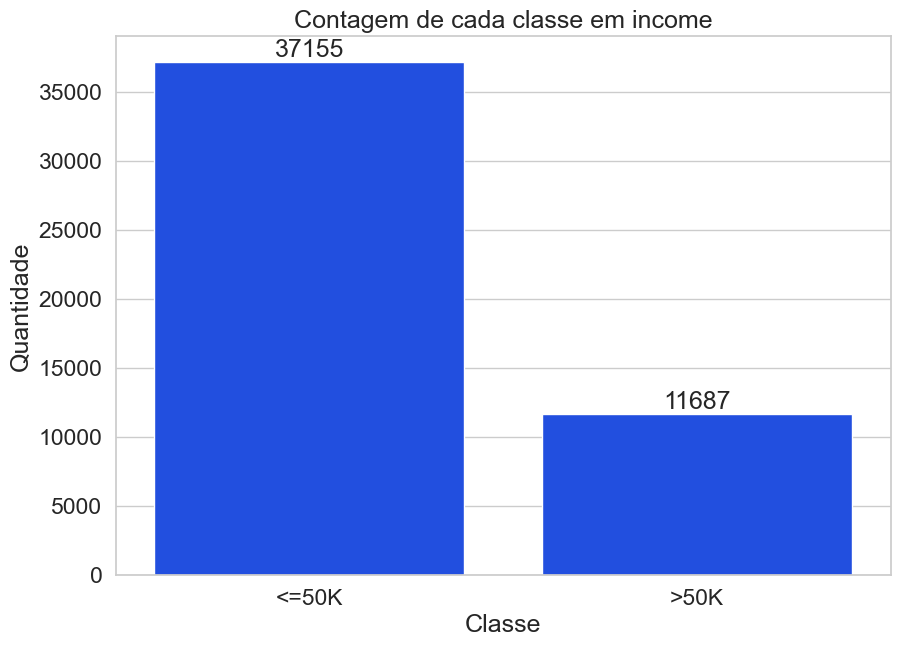

In [8]:
y_df = pd.DataFrame(y);
y_df.columns = ['income']  # Renomeia a coluna do DataFrame de y para o nome original

ax = sns.countplot(x='income', data=y_df) # Plota a contagem de cada classe na variável alvo 'income'
ax.bar_label(ax.containers[0])  # Adiciona rótulos de contagem em cima de cada barra do gráfico

plt.title('Contagem de cada classe em income')  # Define o título do gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

In [9]:
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype('int')

# Map y to binary and convert to int
y_binary = y.map({'>50K': 1, '<=50K': 0}).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df, y_binary, train_size=0.7, random_state=42)

X_train.shape, X_test.shape  # Divide os dados em conjuntos de treino e teste, mapeando as classes para 1 e 0

((34189, 15), (14653, 15))

In [ ]:
try:
    from automlx import init
    # Inicializa o ambiente AutoML com configurações básicas
    init(engine='local', n_workers=1, memory_limit='4GB', verbose=1)
    print("AutoMLx inicializado com sucesso!")
except ImportError:
    print("Erro: biblioteca automlx não encontrada. Por favor instale com 'pip install automlx'")
except Exception as e:
    print(f"Erro ao inicializar AutoMLx: {str(e)}")

In [ ]:
from automlx import Pipeline

# Cria o pipeline diretamente
est1 = Pipeline(task='classification', engine='local', memory_limit='4GB')
est1.fit(X_train, y_train)  # Treina o modelo com os dados de treino

In [ ]:
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test,y_proba[:,1])

print(f'Score on test data: {score_default}')

In [ ]:
est1.print_summary()

In [ ]:
# Cada tentativa é uma tupla de:
# (algoritmo, nº de amostras, nº de features, score médio de CV, hiperparâmetros,
#  todos os scores de CV, tempo total de CV (s), uso de memória (GB))

trials = est1.model_selection_trials_  # Obtém a lista de tentativas de seleção de modelo realizadas pelo AutoML
colors = []  # Lista para armazenar as cores das barras no gráfico

# Extrai apenas os scores médios de validação cruzada (posição 3 da tupla)
scores = [x[3] for x in trials]

# Extrai os nomes dos algoritmos (posição 0 da tupla)
models = [x[0] for x in trials]

# Define a margem de espaço acima e abaixo dos scores para o eixo Y
y_margin = 0.10 * (max(scores) - min(scores))

# Cria uma Series do pandas com os scores indexados pelos modelos, ordenada do maior para o menor score
s = pd.Series(scores, index=models).sort_values(ascending=False)

# Define a cor de cada barra com base no desempenho em relação à média
for f in s.keys():
    if f == '{}_AS'.format(est1.selected_model_):  # Se for o modelo selecionado
        colors.append('orange')  # Cor laranja para o melhor modelo
    elif s[f] > s.mean():  # Se o score for acima da média
        colors.append('teal')  # Cor azul-petróleo
    else:
        colors.append('turquoise')  # Caso contrário, cor turquesa

# Cria o gráfico de barras
fig, ax = plt.subplots(1)

# Define o título do gráfico
ax.set_title("Algorithm Selection Trials")

# Define os limites do eixo Y com margem
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)

# Define o rótulo do eixo Y com a métrica inferida (ex: Acurácia, F1, etc.)
ax.set_ylabel(est1.inferred_score_metric[0])

# Plota as barras com as cores definidas e borda preta
s.plot.bar(ax=ax, color=colors, edgecolor='black')

# Adiciona uma linha horizontal preta indicando o score médio
ax.axhline(y=s.mean(), color='black', linewidth=0.5)

# Mostra o gráfico
plt.show()







In [ ]:
# Cada tentativa é uma tupla de:
# (algoritmo, nº de amostras, nº de features, score médio de CV, hiperparâmetros,
#  todos os scores de CV, tempo total de CV (s), uso de memória (GB))

trials = est1.adaptive_sampling_trials_  # Obtém as tentativas de amostragem adaptativa realizadas pelo AutoML

# Extrai os scores médios de validação cruzada (posição 3 da tupla)
scores = [x[3] for x in trials]

# Extrai o número de amostras usadas em cada tentativa (posição 1 da tupla)
n_samples = [x[1] for x in trials]

# Define uma margem para o eixo Y com base na diferença entre o maior e o menor score
y_margin = 0.10 * (max(scores) - min(scores))

# Cria a figura e o eixo para o gráfico
fig, ax = plt.subplots(1)

# Define o título do gráfico com o nome do algoritmo testado (posição 0 da primeira tupla)
ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))

# Define o rótulo do eixo X como o tamanho da amostra usada no dataset
ax.set_xlabel('Dataset sample size')

# Define o rótulo do eixo Y com a métrica usada no score (ex: Acurácia, F1, etc.)
ax.set_ylabel(est1.inferred_score_metric_)

# Adiciona grade ao gráfico para melhor visualização
ax.grid(color='g', linestyle='--', linewidth=0.1)

# Define os limites do eixo Y com a margem definida
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)

# Plota os pontos com marcador quadrado ("s"), cor teal, e tamanho 3
ax.plot(n_samples, scores, 'k-', marker='s', color='teal', markersize=3)

# Exibe o gráfico
plt.show()
